In [1]:
import pandas as pd
import torch

from tqdm.notebook import tqdm, trange
from utils import *

# UNCHECK THIS OPTION IF YOU ARE ON A MAC
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

## DATA EXTRACTION

In this section the paths of the images are extracted from the dataset and organized into a dataframe to better handle information. Then the images are extracted, resized and normalized to a range of 0-1.

Please note that in order to extract the images, just download the datasets and place them into the same folder of this project. If there are some problems with the extraction consider removing the 'desktop.ini' files.

In [2]:
# CHANGE THIS LINE TO SELECT ANOTHER DATASET
dataset = 'syndrone'        

data = read_images('./' + dataset + '/train')
test_data = read_images('./' + dataset + '/test')

In [3]:
# Use of data frame to better organize data
df = pd.DataFrame(data, columns=["label", "image"])
print(df)

test_df = pd.DataFrame(test_data, columns=["label", "image"])

            label                                    image
0    HardRainNoon  ./syndrone/train/HardRainNoon_02730.png
1      ClearNight    ./syndrone/train/ClearNight_02700.png
2       ClearNoon     ./syndrone/train/ClearNoon_00900.png
3    MidFoggyNoon  ./syndrone/train/MidFoggyNoon_02300.png
4       ClearNoon     ./syndrone/train/ClearNoon_02130.png
..            ...                                      ...
795     ClearNoon     ./syndrone/train/ClearNoon_01420.png
796  MidFoggyNoon  ./syndrone/train/MidFoggyNoon_01610.png
797     ClearNoon     ./syndrone/train/ClearNoon_02840.png
798  HardRainNoon  ./syndrone/train/HardRainNoon_00880.png
799  MidFoggyNoon  ./syndrone/train/MidFoggyNoon_00240.png

[800 rows x 2 columns]


In [4]:
# Extraction of classes
classes = df['label'].unique().tolist()
print(classes)

['HardRainNoon', 'ClearNight', 'ClearNoon', 'MidFoggyNoon']


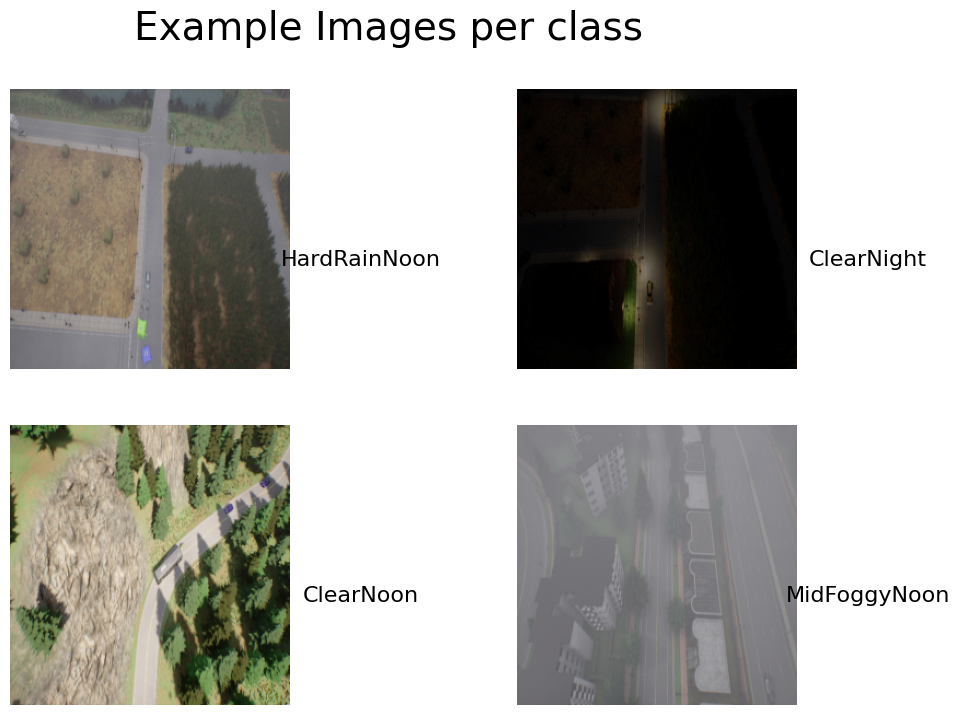

In [43]:
# Print an image from each class as an example
example_images = []

for label in classes:
    example_path = df['image'][df['label'] == label].values[0]
    img = cv.imread(example_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (256, 256), interpolation=cv.INTER_AREA)
    example_images.append(img)

show_images_with_text(example_images, labels=classes, title="Example Images per class", figsize=(12,8))

In [6]:
# Read images from a list of paths and store them in a list of images (this can take several seconds)
image_paths = df['image'].to_numpy()
images = []

image_error = 0

for path in tqdm(image_paths, desc="Image reading"):
    image = cv.imread(path)
    # if implemented to avoid errors on image reading
    if image is not None:
        img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_AREA)
        img = np.array(img, dtype=np.float32) / 255.0
        images.append(img)
    else:
        image_error += 1
        images.append(np.zeros(shape=(256, 256, 3), dtype=np.float32))
    
images = np.array(images, dtype=np.float32)

print("Shape of image array: {}".format(images.shape))
print("Errors encountered: {}".format(image_error))

Image reading:   0%|          | 0/800 [00:00<?, ?it/s]

Shape of image array: (800, 256, 256, 3)
Errors encountered: 0


In [7]:
# Building list of labels as done for images
labels = []
for label in df['label']:
    labels.append(classes.index(label))
    
labels = np.array(labels)

## DATA TRANSFORMATION
In this section the dataset is splitted into training and validation dataset. Next, the two datasets are converted into tensors. Dataset and Dataloader objects are then created from the tensors.

Hyperparams configuration in this section.

In [8]:
from sklearn.model_selection import train_test_split

# Lists of images and labels divided into train and validation lists
images_train, images_validation, labels_train, labels_validation = train_test_split(images, labels, test_size=0.2)

print("Image list shape for train dataset: {}".format(images_train.shape))
print("Label list shape for train dataset: {}".format(labels_train.shape))
print("Image list shape for validation dataset: {}".format(images_validation.shape))
print("Label list shape for validation dataset: {}".format(labels_validation.shape))

Image list shape for train dataset: (640, 256, 256, 3)
Label list shape for train dataset: (640,)
Image list shape for validation dataset: (160, 256, 256, 3)
Label list shape for validation dataset: (160,)


In [9]:
# Train and validation lists respectively transformed into Tensors
images_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
labels_train = torch.from_numpy(labels_train)
images_validation = torch.from_numpy(images_validation).permute(0, 3, 1, 2)
labels_validation = torch.from_numpy(labels_validation)

print("Tensors shape:")
print(images_train.shape)
print(labels_train.shape)
print(images_validation.shape)
print(labels_validation.shape)

Tensors shape:
torch.Size([640, 3, 256, 256])
torch.Size([640])
torch.Size([160, 3, 256, 256])
torch.Size([160])


In [10]:
# Hyperparams configuration
params = {
    'epoch_num': 100,       # number of epochs
    'lr': 1e-4,             # Learning Rate
    'weight_decay': 1e-3,   # L2 Penalty
    'batch_size': 64,       # batch size
    'dropout': 0.32         # dropout regularization
}

In [12]:
# Dataset creation
train_set = ImagesLabelsDataset(images_train, labels_train)
validation_set = ImagesLabelsDataset(images_validation, labels_validation)

# Dataloader creation
train_loader = DataLoader(train_set, params['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_set, params['batch_size'], shuffle=False)

In [13]:
for batch in train_loader:
    img, lbl = batch
    print('Batch shape:')
    print(" - Images: {}".format(img.size()))
    print(" - Labels: {}".format(lbl.size()))
    break

Batch shape:
 - Images: torch.Size([64, 3, 256, 256])
 - Labels: torch.Size([64])


In [ ]:
# Device (GPU or CPU) selection
if torch.cuda.is_available():
    params["device"] = torch.device("cuda")   # option for NVIDIA GPUs
elif torch.backends.mps.is_available():
    params["device"] = torch.device("mps")    # option for Mac M-series chips (GPUs)
else:
    params["device"] = torch.device("cpu")    # default option if none of the above devices are available

print("Device: {}".format(params["device"]))

## TRAINING PHASE USING A SIMPLE CNN
In this section the ConvolutionalModel is trained and validated with respectively training and validation dataloaders. Then the results are shown.

In [14]:
import torch.nn as nn
from models import ConvolutionalModel
from models import train, validate

In [15]:
# Model initialization
model = ConvolutionalModel(len(classes), dropout=params['dropout']).to(params["device"])

In [16]:
# Loss and optimizer choice
criterion = nn.CrossEntropyLoss().to(params["device"])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = params["lr"],
    weight_decay = params["weight_decay"]
)

In [17]:
# Training and Validation phase for the selected model (simple CNN)
train_losses, validation_losses, train_acc, validation_acc = list(), list(), list(), list()

# Just some fancy progress bars
pbar_epoch = trange(params["epoch_num"], desc="Training")
pbar_inside_epoch = tqdm(total = (len(train_loader)+len(validation_loader)), desc="Training and validation per epoch", position=1, leave=True)

# Stop the training phase in case there is no improvement
early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()
    
    train_results = train(train_loader, model, epoch, criterion, optimizer, params["device"], pbar=pbar_inside_epoch)
    train_losses.append(train_results[0])
    train_acc.append(1 - train_results[1])
    
    validation_results = validate(validation_loader, model, epoch, criterion, params["device"], pbar=pbar_inside_epoch)
    validation_losses.append(validation_results[0])
    validation_acc.append(1 - validation_results[1])
    
    # Comment on the following lines if you don't want to stop early in case of no improvement
    if early_stopper.early_stop(validation_results[0]):
        params['epoch_num'] = epoch
        print("\n\nEarly stopping...")
        break

pbar_inside_epoch.close()

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training and validation per epoch:   0%|          | 0/13 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 1
 - Loss: 1.290 +- 0.079
 - Accuracy: 0.53
 - Time: 1.14s

-- VALIDATION --
Epoch: 1
 - Loss: 1.384 +- 0.013
 - Accuracy: 0.24
 - Time: 0.15s

-- TRAINING --
Epoch: 2
 - Loss: 1.066 +- 0.057
 - Accuracy: 0.75
 - Time: 0.46s

-- VALIDATION --
Epoch: 2
 - Loss: 1.328 +- 0.032
 - Accuracy: 0.24
 - Time: 0.07s

-- TRAINING --
Epoch: 3
 - Loss: 0.922 +- 0.061
 - Accuracy: 0.79
 - Time: 0.49s

-- VALIDATION --
Epoch: 3
 - Loss: 1.179 +- 0.036
 - Accuracy: 0.54
 - Time: 0.06s

-- TRAINING --
Epoch: 4
 - Loss: 0.809 +- 0.037
 - Accuracy: 0.85
 - Time: 0.49s

-- VALIDATION --
Epoch: 4
 - Loss: 0.915 +- 0.026
 - Accuracy: 0.79
 - Time: 0.07s

-- TRAINING --
Epoch: 5
 - Loss: 0.712 +- 0.044
 - Accuracy: 0.90
 - Time: 0.45s

-- VALIDATION --
Epoch: 5
 - Loss: 0.679 +- 0.015
 - Accuracy: 0.94
 - Time: 0.06s

-- TRAINING --
Epoch: 6
 - Loss: 0.637 +- 0.038
 - Accuracy: 0.95
 - Time: 0.45s

-- VALIDATION --
Epoch: 6
 - Loss: 0.536 +- 0.009
 - Accuracy: 0.98
 - Time: 0.06s

-- 

In [18]:
# SAVING MODEL PARAMETERS
# torch.save(model.state_dict(), './trained_models/model_weights_{}.pth'.format(dataset))       # Uncomment this line to save the model

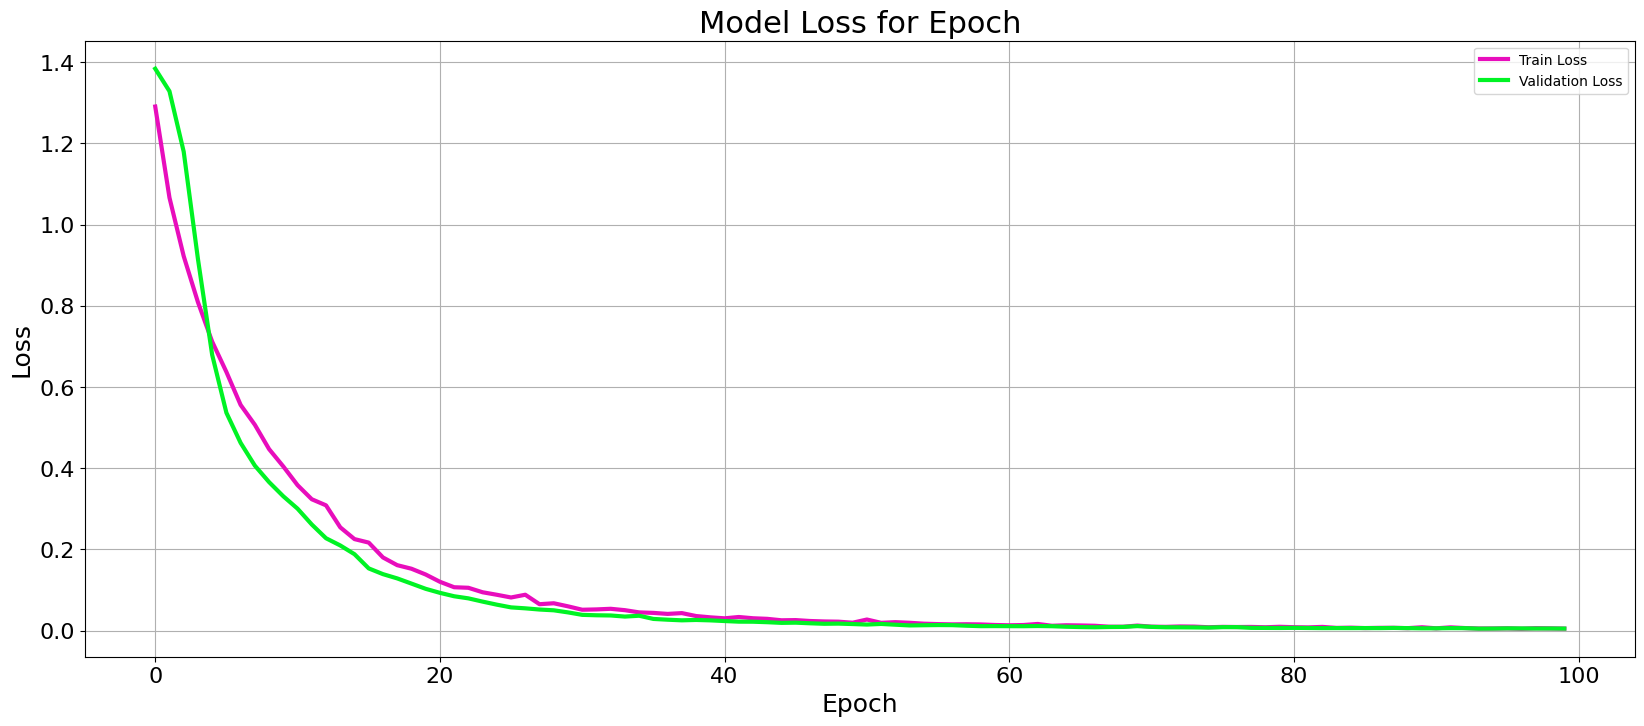

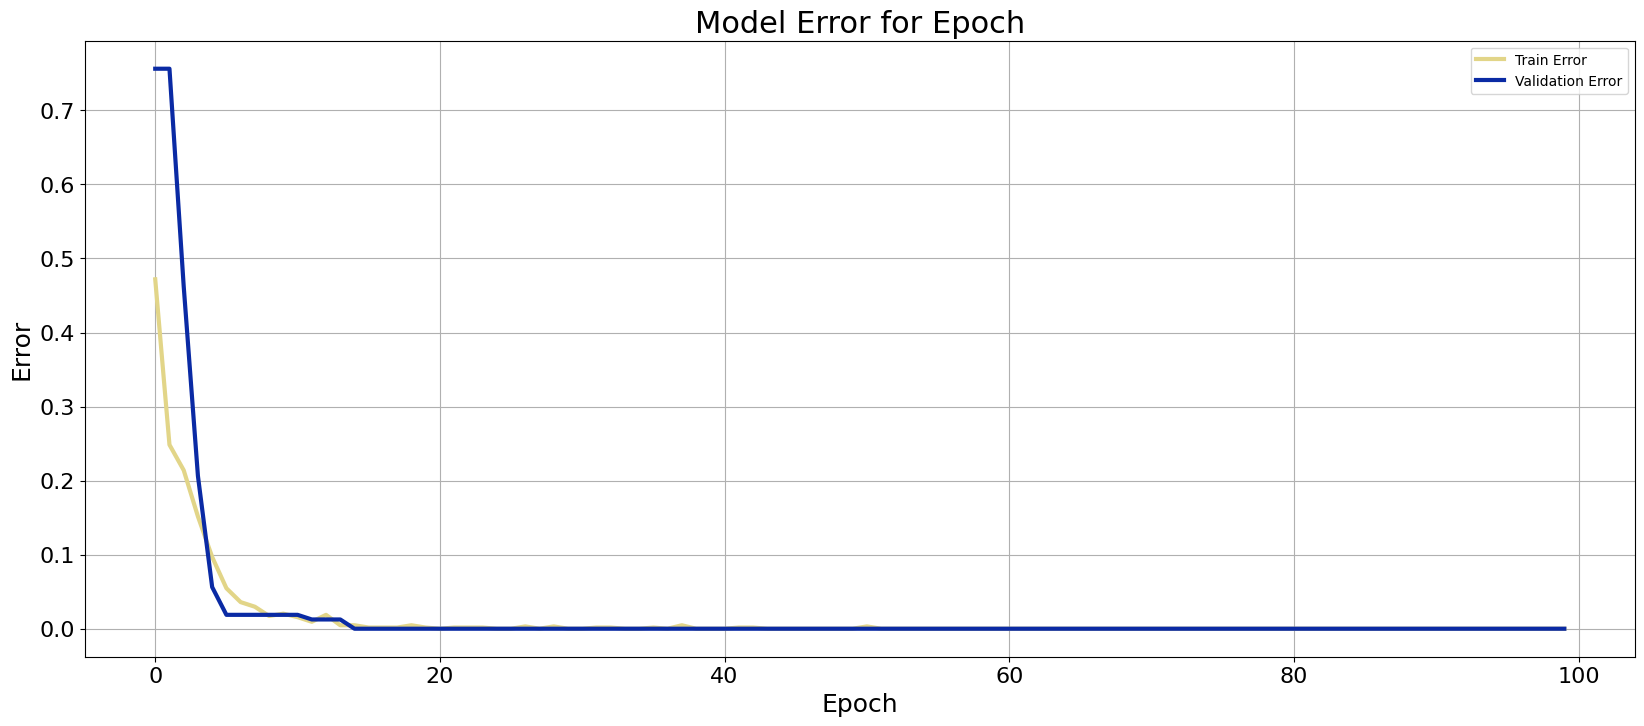

In [19]:
# Plotting the performance of the model in the training and validation phase
plots = [
    (np.arange(0, params["epoch_num"], 1), train_losses, "Train Loss"),
    (np.arange(0, params["epoch_num"], 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, params["epoch_num"], 1), train_acc, "Train Error"),
    (np.arange(0, params["epoch_num"], 1), validation_acc, "Validation Error")
]

show_plot(plots, "Model Error for Epoch", "Epoch", "Error")

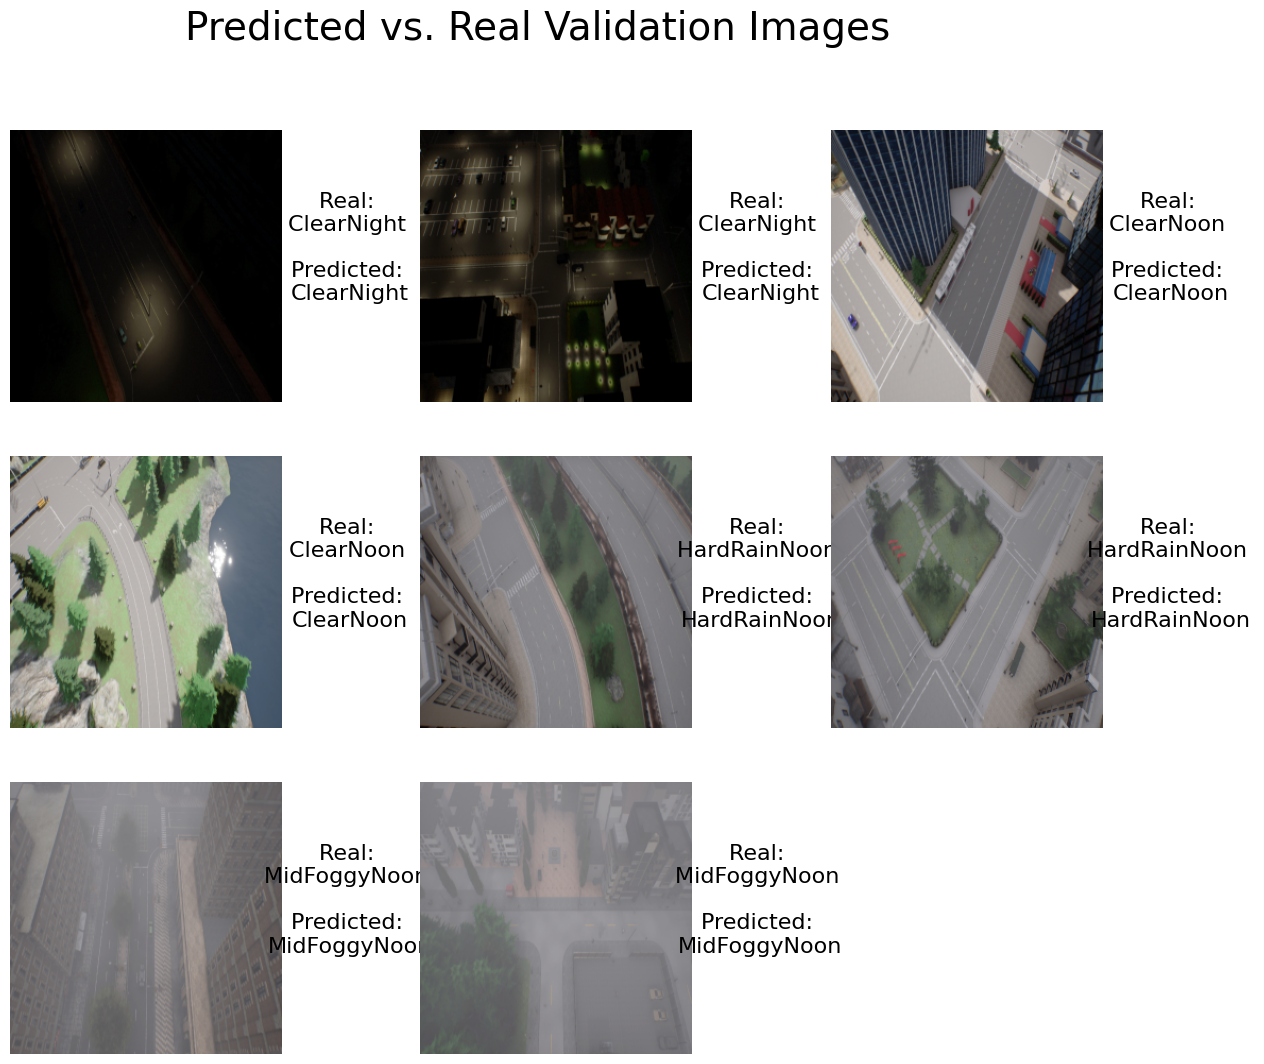

In [20]:
# Showing the results with a series of images comparing the predicted value and the actual value of the images
sample_labels = classes * 2
sample_labels.sort()

sample_paths = np.array([])
np.random.seed(60)
for label in sample_labels:
    sample = df.query("label == '%s'" % label).sample(1)
    sample_paths = np.append(sample_paths, sample["image"].values)

sample_images = list()
sample_text = list()

for path, label in zip(sample_paths, sample_labels):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (256, 256), interpolation=cv.INTER_AREA)
    sample_images.append(image)

    image = np.array(image, dtype=np.float32)/255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(params["device"])
    index = np.argmax(model(image_tensor).cpu().detach().numpy())
    y_predicted = classes[index]

    sample_text.append("Real: \n{} \n\nPredicted: \n{}".format(label, y_predicted))

show_images_with_text(sample_images, sample_text, "Predicted vs. Real Validation Images", figsize=(15,12))

## TRAINING PHASE USING RESNET CNN

In this section the same step as above are followed, but instead the ResNet CNN is used. 

In [21]:
# Mean and Standard Deviation computation from the dataloaders
train_mean, train_std = compute_mean_std(train_loader)
validation_mean, validation_std = compute_mean_std(validation_loader)

print(train_mean, train_std)
print(validation_mean, validation_std)

tensor([0.3900, 0.3859, 0.3654]) tensor([0.2360, 0.2310, 0.2280])
tensor([0.3826, 0.3783, 0.3539]) tensor([0.2304, 0.2249, 0.2216])


In [22]:
import torchvision.transforms as tt

# Transform objects
train_transform = tt.Compose([tt.RandomHorizontalFlip(), tt.Normalize(train_mean, train_std)])
validation_transform = tt.Compose([tt.Normalize(validation_mean, validation_std)])

# Normalized Dataset to use normalized data in the training phase
norm_train_set = ImagesLabelsDataset(images_train, labels_train, transforms=train_transform)
norm_validation_set = ImagesLabelsDataset(images_validation, labels_validation, transforms=validation_transform)

In [23]:
from models import ResidualBlock, ResNet

# Hyperparams configuration
params['epoch_num'] = 50
params['lr'] = 1e-4
params['weight_decay'] = 1e-4
params['momentum'] = 0.6

# Dataloader
train_loader = DataLoader(train_set, params['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_set, params['batch_size'], shuffle=False)

# Model configuration
resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=len(classes)).to(params['device'])

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    resnet.parameters(), 
    lr=params['lr'], 
    weight_decay=params['weight_decay'],
    #momentum=params['momentum']
)

# Train and validation
train_losses, validation_losses, train_acc, validation_acc = list(), list(), list(), list()

# Just some fancy progress bars
pbar_epoch = trange(params["epoch_num"], desc="Training")
pbar_inside_epoch = tqdm(total = (len(train_loader)+len(validation_loader)), desc="Training and validation per epoch", position=1, leave=True)

# Stop the training phase in case there is no improvement
early_stopper = EarlyStopper(patience=10, min_delta=0.1)

for epoch in pbar_epoch:
    pbar_inside_epoch.reset()
    
    train_results = train(train_loader, resnet, epoch, criterion, optimizer, params["device"], pbar=pbar_inside_epoch)
    train_losses.append(train_results[0])
    train_acc.append(1 - train_results[1])
    
    validation_results = validate(validation_loader, resnet, epoch, criterion, params["device"], pbar=pbar_inside_epoch)
    validation_losses.append(validation_results[0])
    validation_acc.append(1 - validation_results[1])

    # Comment on the following lines if you don't want to stop early in case of no improvement
    if early_stopper.early_stop(validation_results[0]):
        params['epoch_num'] = epoch
        print("\n\nEarly stopping...")
        break
    
pbar_inside_epoch.close()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Training and validation per epoch:   0%|          | 0/13 [00:00<?, ?it/s]


-- TRAINING --
Epoch: 1
 - Loss: 0.229 +- 0.397
 - Accuracy: 0.89
 - Time: 7.94s

-- VALIDATION --
Epoch: 1
 - Loss: 2.544 +- 0.085
 - Accuracy: 0.24
 - Time: 0.60s

-- TRAINING --
Epoch: 2
 - Loss: 0.031 +- 0.042
 - Accuracy: 0.99
 - Time: 7.26s

-- VALIDATION --
Epoch: 2
 - Loss: 6.159 +- 0.120
 - Accuracy: 0.24
 - Time: 0.50s

-- TRAINING --
Epoch: 3
 - Loss: 0.010 +- 0.015
 - Accuracy: 1.00
 - Time: 7.26s

-- VALIDATION --
Epoch: 3
 - Loss: 7.874 +- 0.599
 - Accuracy: 0.24
 - Time: 0.50s

-- TRAINING --
Epoch: 4
 - Loss: 0.010 +- 0.020
 - Accuracy: 0.99
 - Time: 7.28s

-- VALIDATION --
Epoch: 4
 - Loss: 5.698 +- 0.726
 - Accuracy: 0.53
 - Time: 0.54s

-- TRAINING --
Epoch: 5
 - Loss: 0.037 +- 0.061
 - Accuracy: 0.99
 - Time: 7.27s

-- VALIDATION --
Epoch: 5
 - Loss: 4.322 +- 0.351
 - Accuracy: 0.56
 - Time: 0.49s

-- TRAINING --
Epoch: 6
 - Loss: 0.108 +- 0.190
 - Accuracy: 0.98
 - Time: 7.26s

-- VALIDATION --
Epoch: 6
 - Loss: 0.243 +- 0.090
 - Accuracy: 0.95
 - Time: 0.49s

-- 

In [24]:
# SAVING MODEL PARAMETERS
# torch.save(resnet.state_dict(), './trained_models/resnet_weights_{}.pth'.format(dataset))     # Uncomment this line to save the model

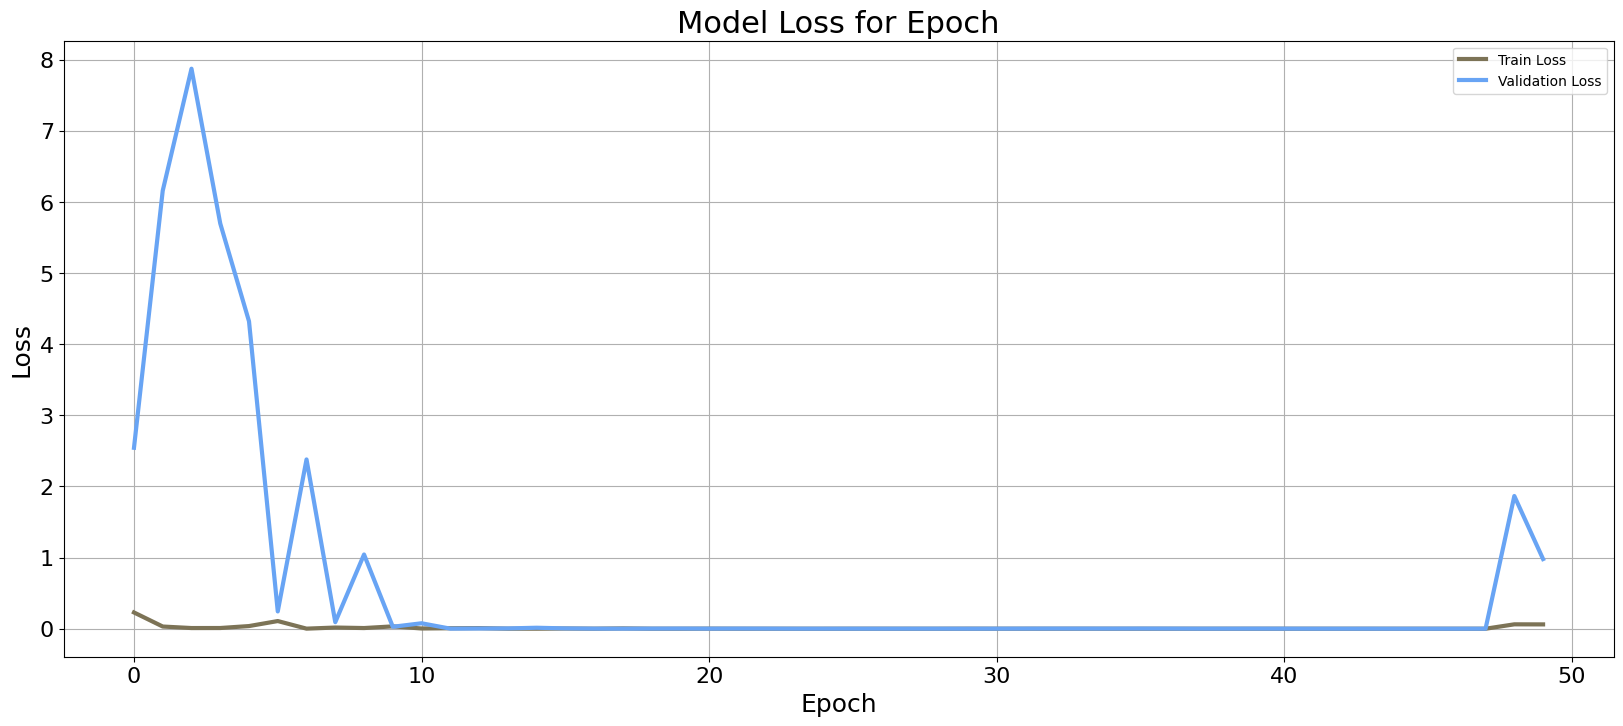

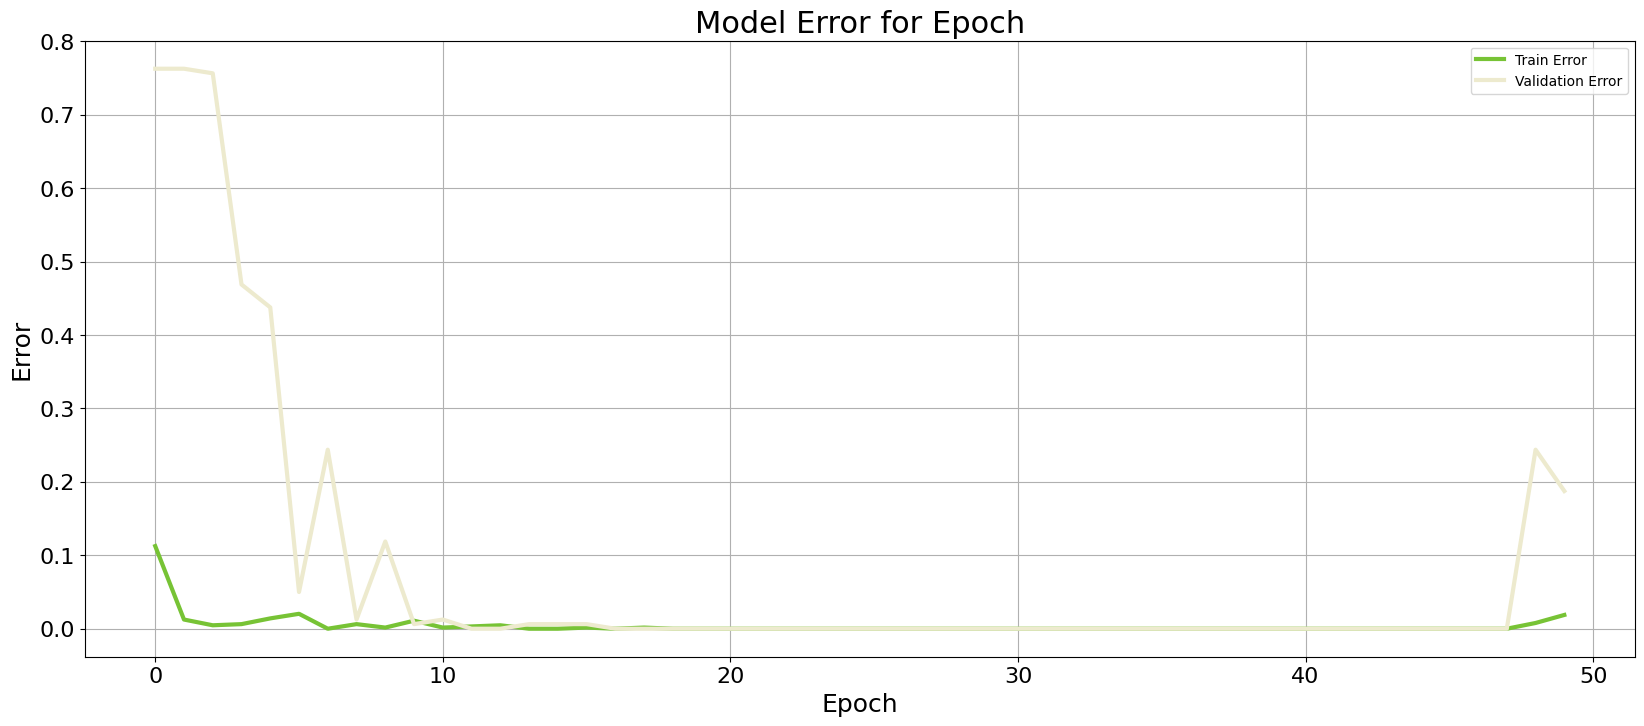

In [25]:
# Plotting the performance of the model in the training and validation phase

plots = [
    (np.arange(0, params["epoch_num"], 1), train_losses, "Train Loss"),
    (np.arange(0, params["epoch_num"], 1), validation_losses, "Validation Loss")
]

show_plot(plots, "Model Loss for Epoch", "Epoch", "Loss")

plots = [
    (np.arange(0, params["epoch_num"], 1), train_acc, "Train Error"),
    (np.arange(0, params["epoch_num"], 1), validation_acc, "Validation Error")
]

show_plot(plots, "Model Error for Epoch", "Epoch", "Error")

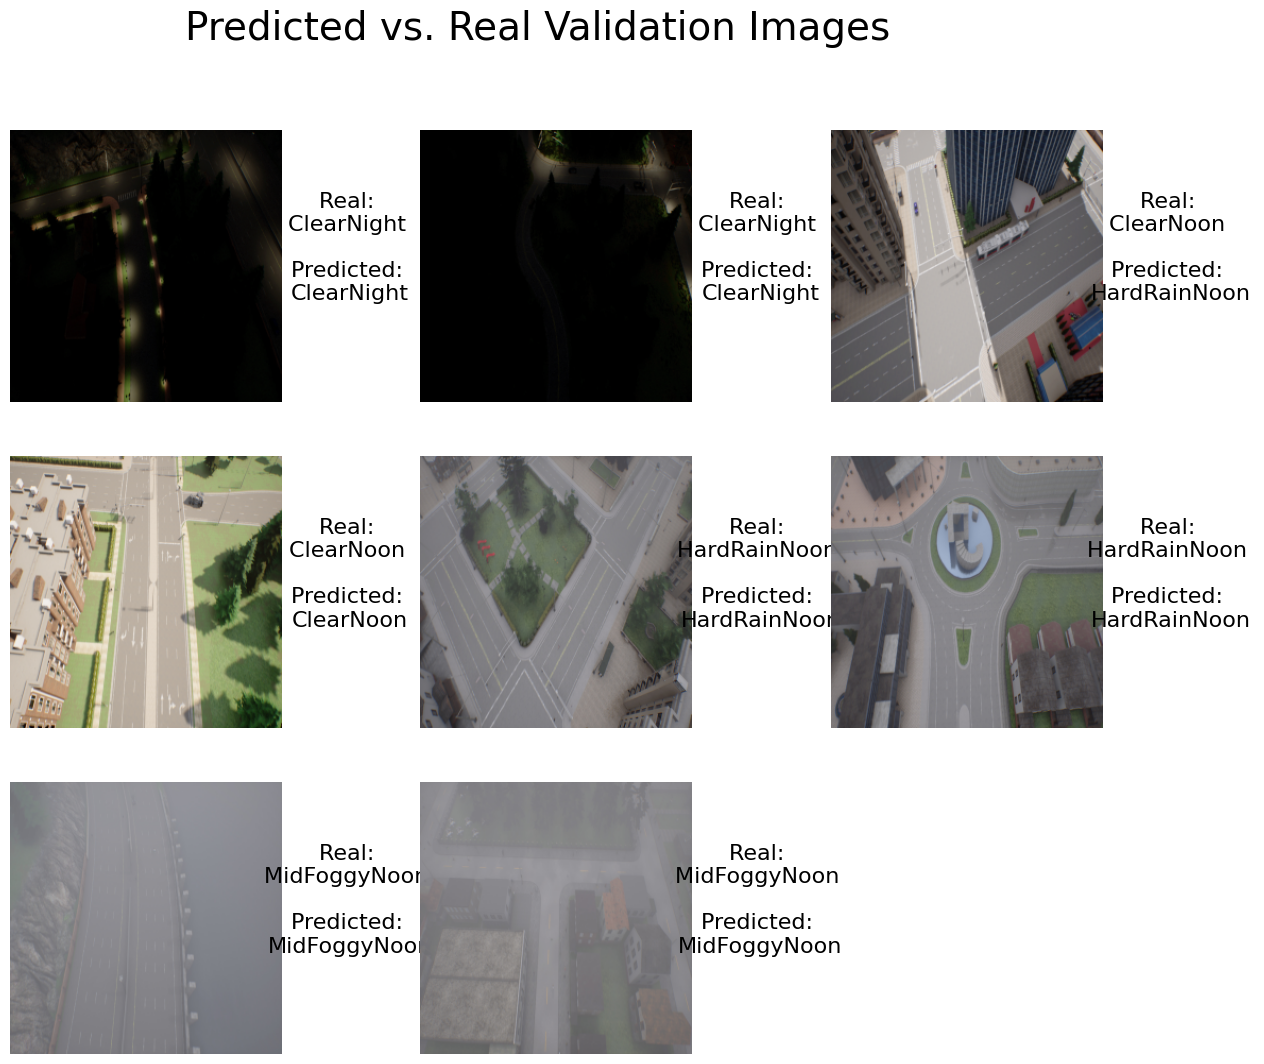

In [26]:
# Showing the results with a series of images comparing the predicted value and the actual value of the images
sample_labels = classes * 2
sample_labels.sort()

sample_paths = np.array([])
np.random.seed(40)
for label in sample_labels:
    sample = df.query("label == '%s'" % label).sample(1)
    sample_paths = np.append(sample_paths, sample["image"].values)

sample_images = list()
sample_text = list()

for path, label in zip(sample_paths, sample_labels):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (256, 256), interpolation=cv.INTER_AREA)
    sample_images.append(image)

    image = np.array(image, dtype=np.float32)/255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(params["device"])
    index = np.argmax(resnet(image_tensor).cpu().detach().numpy())
    y_predicted = classes[index]

    sample_text.append("Real: \n{} \n\nPredicted: \n{}".format(label, y_predicted))

show_images_with_text(sample_images, sample_text, "Predicted vs. Real Validation Images", figsize=(15, 12))

## PREDICT NEW IMAGES USING TEST DATASET

In this section the models are tested with the test dataset. The images are uploaded and then fed to the models. Results are shown below.

In [27]:
test_image_paths = test_df['image'].to_numpy()
test_images = []

image_error = 0

for path in tqdm(test_image_paths, desc="Image reading"):
    image = cv.imread(path)
    if image is not None:
        img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (256, 256), interpolation=cv.INTER_AREA)
        img = np.array(img, dtype=np.float32)/255.0
        test_images.append(img)
    else:
        image_error += 1
        test_images.append(np.zeros(shape=(256, 256, 3), dtype=np.float32))

test_images = np.array(test_images, dtype=np.float32)

print(test_images.shape)
print("Errors: {}".format(image_error))

Image reading:   0%|          | 0/400 [00:00<?, ?it/s]

(400, 256, 256, 3)
Errors: 0


In [28]:
test_labels = []
for label in test_df['label']:
    test_labels.append(classes.index(label))

test_labels = np.array(test_labels)

test_images = torch.from_numpy(test_images).permute(0, 3, 1, 2)
test_labels = torch.from_numpy(test_labels)

print(test_images.shape)
print(test_labels.shape)

torch.Size([400, 3, 256, 256])
torch.Size([400])


In [29]:
# Test Dataset
test_set = ImagesLabelsDataset(test_images, test_labels)

# Dataloader
test_loader = DataLoader(test_set, batch_size=params['batch_size'])

# Normalized Test Dataset
test_mean, test_std = compute_mean_std(test_loader)
test_transform = tt.Compose([tt.Normalize(test_mean, test_std)])
norm_test_set = ImagesLabelsDataset(test_images, test_labels, transforms=test_transform)

# Normalized Dataloader
norm_test_loader = DataLoader(norm_test_set, batch_size=params['batch_size'])

In [30]:
from models import test    

In [31]:
# Test using simple model
test_loss, test_acc = test(test_loader, model, criterion, params["device"])


-- TEST --
Test results:
 - Loss: 0.004 +- 0.001
 - Accuracy: 1.00
 - Time: 0.66s


In [32]:
# Test using ResNet
resnet_test_loss, resnet_test_acc = test(test_loader, resnet, criterion, params["device"])


-- TEST --
Test results:
 - Loss: 0.923 +- 0.280
 - Accuracy: 0.81
 - Time: 1.55s


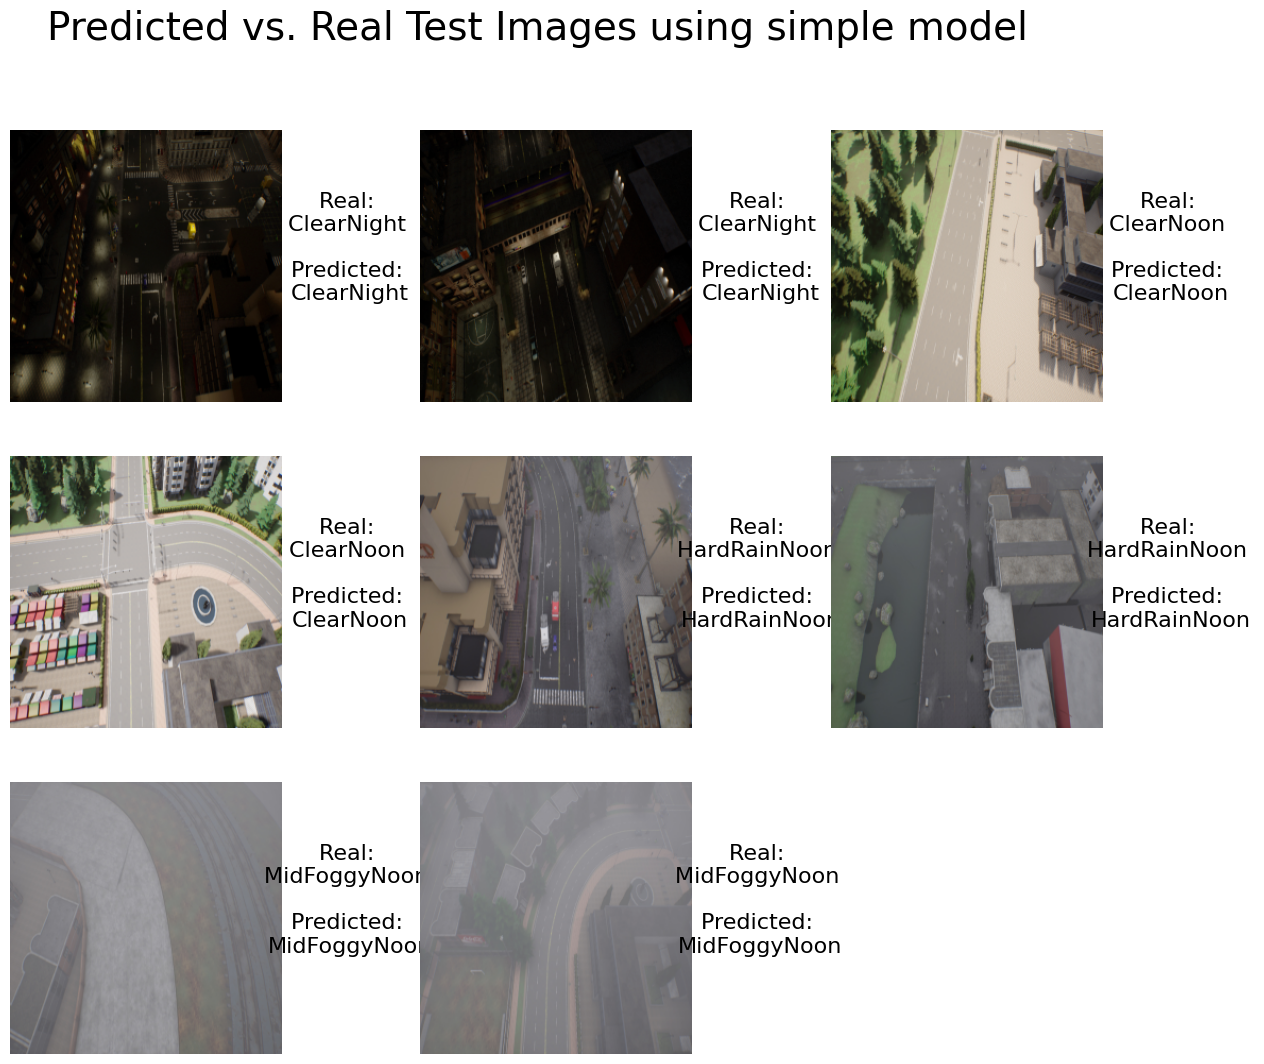

In [33]:
sample_labels = classes * 2
sample_labels.sort()

sample_paths = np.array([])
np.random.seed(40)
for label in sample_labels:
    sample = test_df.query("label == '%s'" % label).sample(1)
    sample_paths = np.append(sample_paths, sample["image"].values)

sample_images = list()
sample_text = list()

for path, label in zip(sample_paths, sample_labels):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (256, 256), interpolation=cv.INTER_AREA)
    sample_images.append(image)

    image = np.array(image, dtype=np.float32)/255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(params["device"])
    index = np.argmax(model(image_tensor).cpu().detach().numpy())
    y_predicted = classes[index]

    sample_text.append("Real: \n{} \n\nPredicted: \n{}".format(label, y_predicted))

show_images_with_text(sample_images, sample_text, "Predicted vs. Real Test Images using simple model", figsize=(15, 12))

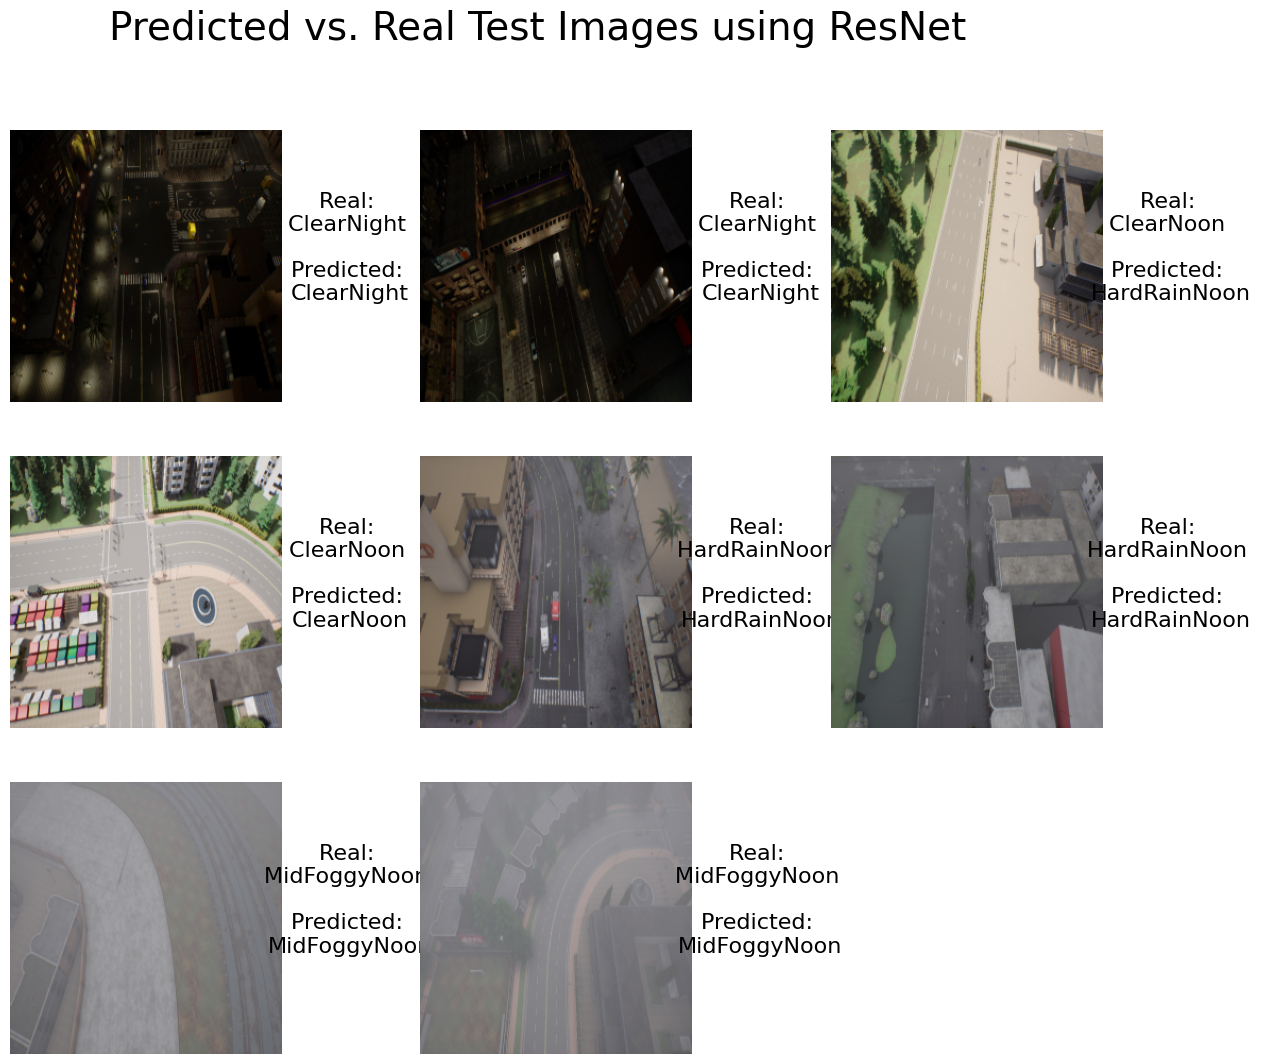

In [34]:
sample_labels = classes * 2
sample_labels.sort()

sample_paths = np.array([])
np.random.seed(40)
for label in sample_labels:
    sample = test_df.query("label == '%s'" % label).sample(1)
    sample_paths = np.append(sample_paths, sample["image"].values)

sample_images = list()
sample_text = list()

for path, label in zip(sample_paths, sample_labels):
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (256, 256), interpolation=cv.INTER_AREA)
    sample_images.append(image)

    image = np.array(image, dtype=np.float32)/255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(params["device"])
    index = np.argmax(resnet(image_tensor).cpu().detach().numpy())
    y_predicted = classes[index]

    sample_text.append("Real: \n{} \n\nPredicted: \n{}".format(label, y_predicted))

show_images_with_text(sample_images, sample_text, "Predicted vs. Real Test Images using ResNet", figsize=(15, 12))

In [35]:
import gc
# Free Memory
del images, test_images
gc.collect()